**Numerical Analysis**

**Attention layer with LSTM**

In [20]:
#import the necesssary libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
import xgboost 
import lightgbm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label = 'Real BSESN Stock Price')
    plt.plot(predicted, color='blue',label = 'Predicted BSESN Stock Price')
    plt.title('BSESN Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('BSESN Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [22]:
pip install yfinance

In [23]:
import yfinance as yf
bse_data = yf.download('^BSESN', start='2001-01-02', end='2004-12-13')

[*********************100%***********************]  1 of 1 completed


In [24]:
dataset = bse_data
#dataset.set_index("Date", inplace = True)
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-06,6351.040039,6386.290039,6312.129883,6322.500000,6322.500000,18800
2004-12-07,6324.069824,6354.259766,6287.459961,6316.279785,6316.279785,17800
2004-12-08,6333.040039,6359.200195,6250.240234,6261.520020,6261.520020,26000
2004-12-09,6259.500000,6319.009766,6241.270020,6304.270020,6304.270020,19400
2004-12-10,6328.100098,6336.899902,6221.399902,6233.540039,6233.540039,17600


In [25]:
dataset.reset_index(inplace=True)
dataset.rename(columns={'Date': 'date'}, inplace = True)
dataset.rename(columns={'date': 'Date'}, inplace = True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [26]:
#Getting "High" attribute
df2 = dataset['High']
df2.head

<bound method NDFrame.head of 0      4028.570068
1      4067.659912
2      4180.970215
3      4195.009766
4      4206.720215
          ...     
978    6386.290039
979    6354.259766
980    6359.200195
981    6319.009766
982    6336.899902
Name: High, Length: 983, dtype: float64>

In [27]:
#In the above, no index is present. The data is presented as Date, values
#We need the index number for the mc learning model 
#Therefore, use 'reset_index' method to get the index.

#get attribute 'Close'
df1 = dataset.reset_index()['High']
df1

0      4028.570068
1      4067.659912
2      4180.970215
3      4195.009766
4      4206.720215
          ...     
978    6386.290039
979    6354.259766
980    6359.200195
981    6319.009766
982    6336.899902
Name: High, Length: 983, dtype: float64

In [28]:
dataset.size

6881

In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       983 non-null    datetime64[ns]
 1   Open       983 non-null    float64       
 2   High       983 non-null    float64       
 3   Low        983 non-null    float64       
 4   Close      983 non-null    float64       
 5   Adj Close  983 non-null    float64       
 6   Volume     983 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 53.9 KB


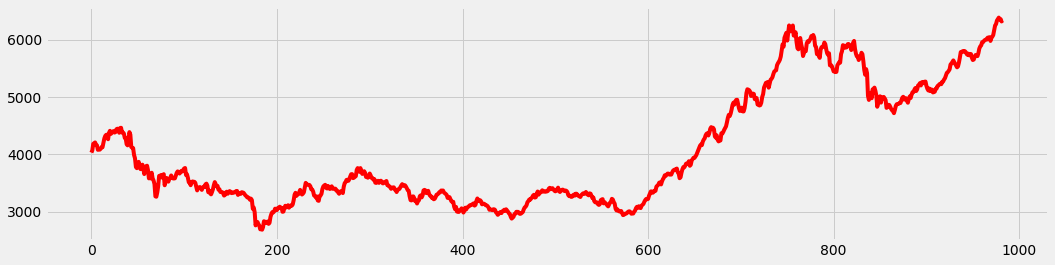

In [30]:
#PLot data
#..........Method 2
dataset['High'].plot(figsize=(16,4) , color = 'red' )
plt.show()

In [31]:
# Reshape the dataset 
df1 = np.array(df1).reshape(-1 , 1)
df1[:5]

array([[4028.57006836],
       [4067.65991211],
       [4180.97021484],
       [4195.00976562],
       [4206.72021484]])

In [32]:
# split the data into train and test data
trainSize = int(len(df1)*0.67)
testSize = len(df1) - trainSize
trainData , testData = df1[0:trainSize , : ] , df1[trainSize : len(df1),:1]

#df1[a :b , c: d] format is present because dataset has rows and column.

In [33]:
trainData[:5]

array([[4028.57006836],
       [4067.65991211],
       [4180.97021484],
       [4195.00976562],
       [4206.72021484]])

In [34]:
testData[:5]

array([[4160.02001953],
       [4222.39013672],
       [4256.06982422],
       [4277.64013672],
       [4329.56982422]])

In [35]:
trainData = np.log(trainData) 
testData = np.log(testData)
trainData[:5]

array([[8.30116677],
       [8.31082315],
       [8.33829861],
       [8.34165095],
       [8.34443858]])

In [36]:
testData[:5]

array([[8.33327517],
       [8.34815663],
       [8.35610144],
       [8.36115677],
       [8.37322347]])

In [37]:
# Scaling the data
# Line 1 : Def Scaling to range (0,1)
# Line 2 : Scaling
scaler = MinMaxScaler(feature_range=(0,1))
trainData = scaler.fit_transform(trainData)

In [38]:
trainData[:5]

array([[0.79913049],
       [0.81810778],
       [0.87210415],
       [0.87869236],
       [0.88417078]])

In [39]:
trainData.shape

(658, 1)

In [40]:
# Now create the xTrain and yTrain from the trainData(i.e training data)

xTrain, yTrain = [] , []

for i in range(60, 658):
    xTrain.append(trainData[i-60 : i , 0])
    yTrain.append(trainData[i,0])

xTrain, yTrain = np.array(xTrain) , np.array(yTrain)

In [41]:
xTrain.shape

(598, 60)

In [42]:
##Reshaping xTrain for efficient modelling
#xTrain = xTrain.reshape(-1 , 1)

#Reshaping xTrain for efficient modelling
xTrain = np.reshape(xTrain , (xTrain.shape[0] , xTrain.shape[1] , 1))

In [43]:
xTrain.shape

(598, 60, 1)

### **Attention**

In [44]:
pip install attention

In [45]:
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model
from attention import Attention

In [46]:
# Attention layer
time_steps, input_dim, output_dim =  60, 1, 1

# Define/compile the model.
model_input = Input(shape=(time_steps, input_dim))
x = LSTM(64, return_sequences=True)(model_input)
x = Attention(32)(x)
x = Dense(1)(x)
model = Model(model_input, x)
model.compile(loss='mean_squared_error', optimizer='rmsprop')
#print(model.summary())

# train.
#model.fit(xTrain, yTrain, epochs=10)
model.fit(xTrain, yTrain, epochs=50, batch_size = 32)

Epoch 1/50
19/19 [==============================] - 2s 26ms/step - loss: 0.0213
Epoch 2/50
19/19 [==============================] - 1s 26ms/step - loss: 0.0061
Epoch 3/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0043
Epoch 4/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0036
Epoch 5/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0026
Epoch 6/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0028
Epoch 7/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0024
Epoch 8/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0025
Epoch 9/50
19/19 [==============================] - 1s 26ms/step - loss: 0.0023
Epoch 10/50
19/19 [==============================] - 1s 27ms/step - loss: 0.0018
Epoch 11/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0021
Epoch 12/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0018
Epoch 13/50
19/19 [==================

In [47]:
#Get test set ready as similar to traing set
#create a whole dataset
dataset_total = (dataset["High"])
dataset_total.shape

(983,)

In [48]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = (dataset["High"])
inputs = dataset_total[len(dataset_total)-len(testData) - 60:].values
inputs = np.log(inputs)
inputs = inputs.reshape(-1,1)
inputs = scaler.fit_transform(inputs)
inputs[:5]


array([[0.00263037],
       [0.        ],
       [0.00265301],
       [0.026992  ],
       [0.04427768]])

In [49]:
inputs[:5]

array([[0.00263037],
       [0.        ],
       [0.00265301],
       [0.026992  ],
       [0.04427768]])

In [50]:
inputs.shape

(385, 1)

In [51]:
# Create xTest and yTest from testData(i.e. testing data)
# 60 timestep and 1 output
xTest = []

for i in range(60, 385):
    xTest.append(inputs[i-60 : i , 0])
  

xTest = np.array(xTest) 
xTest = np.reshape(xTest, (xTest.shape[0],xTest.shape[1],1))


In [52]:
# Predict model
predicted_stock_price = model.predict(xTest)
predicted_stock_price2 = scaler.inverse_transform(predicted_stock_price)

In [53]:
predicted_stock_price2[:5]

array([[8.3442545],
       [8.340862 ],
       [8.356912 ],
       [8.3642025],
       [8.368757 ]], dtype=float32)

In [54]:
testData[:5]

array([[8.33327517],
       [8.34815663],
       [8.35610144],
       [8.36115677],
       [8.37322347]])

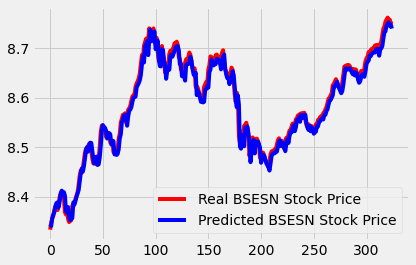

In [88]:
plt.plot(testData, color='red',label='Real BSESN Stock Price')
plt.plot(predicted_stock_price2, color='blue',label='Predicted BSESN Stock Price')
plt.xlabel = 'Time'
plt.ylabel = 'BSESN Stock price'
plt.legend()
plt.show()

In [56]:
rmse = math.sqrt(mean_squared_error(testData, predicted_stock_price2))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.013541360729379615.


Texual Analysis

In [57]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [58]:
cols = ['Date','Category','News']
df_news = pd.read_csv('/content/gdrive/My Drive/india-news-headlines.csv.crdownload', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
1569822,20130225,rail-budget,Karnataka urges railway ministry to sanction 1...
1569823,20130225,entertainment.hindi.bollywood,Rohan Sippy to do cameo in 'Nautanki Saala'
1569824,20130225,entertainment.bhojpuri.movies.news,Rakhela Shaan Bhojpuriya Jawaan to release on ...
1569825,20130225,entertainment.hindi.bollywood,Jacqueline Fernandez doing item number with Pr...


In [59]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1569826 entries, 1 to 1569826
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Date    1569826 non-null  object
 1   News    1569825 non-null  object
dtypes: object(2)
memory usage: 35.9+ MB


In [60]:
df_news.head()

,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic


In [61]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news.head()

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic


In [62]:
#check nan value
df_news['News'].isnull().values.any()
df_news['News'].fillna('Hello', inplace=True)

In [63]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
4391,2013-02-21,Fellow Satsangis help you to evolve Most of Rs...
4392,2013-02-22,Arun Jaitley cell tap probe: Businessman's cal...
4393,2013-02-23,Pics: Celebs spotted in see-through outfits Tr...
4394,2013-02-24,New Gurgaon emerging as a lifestyle destinatio...


In [64]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
4391    Fellow Satsangis help you to evolve Most of Rs...
4392    Arun Jaitley cell tap probe: Businessman's cal...
4393    Pics: Celebs spotted in see-through outfits Tr...
4394    New Gurgaon emerging as a lifestyle destinatio...
4395    Missed opportunity for aspiring athletes Organ...
Name: News, Length: 4396, dtype: object

In [65]:
df_news.drop(df_news.loc[1400:].index, inplace=True)
df_news.tail()

,Date,News
1395,2004-12-09,Madras HC refuses to grant bail to Kanchi seer...
1396,2004-12-10,Politicians most corrupt; say Indians Brute fo...
1397,2004-12-11,Keep channels open; Trai tells broadcasters US...
1398,2004-12-12,Stripped; tonsured; flogged... all for love Bo...
1399,2004-12-13,Big-B lends voice to magic of Tagore AHA on an...


In [66]:
ps = PorterStemmer()

In [67]:
#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)
print("Finish")

Finish


In [68]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
1,2001-01-03,powerless north india grope dark think laxman ...
2,2001-01-04,string pull stephen hawk india vajpaye give bi...
3,2001-01-05,light combat craft take india club class hawk ...
4,2001-01-06,light combat craft take india club class hawk ...
...,...,...
1395,2004-12-09,madra hc refus grant bail kanchi seer india ho...
1396,2004-12-10,politician corrupt say indian brute forc engli...
1397,2004-12-11,keep channel open trai tell broadcast us waiv ...
1398,2004-12-12,strip tonsur flog love bomb blast srk show kil...


In [69]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [70]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394
...,...,...,...,...
1395,2004-12-09,madra hc refus grant bail kanchi seer india ho...,0.483466,0.044768
1396,2004-12-10,politician corrupt say indian brute forc engli...,0.323097,0.124429
1397,2004-12-11,keep channel open trai tell broadcast us waiv ...,0.368564,0.091771
1398,2004-12-12,strip tonsur flog love bomb blast srk show kil...,0.403276,0.106394


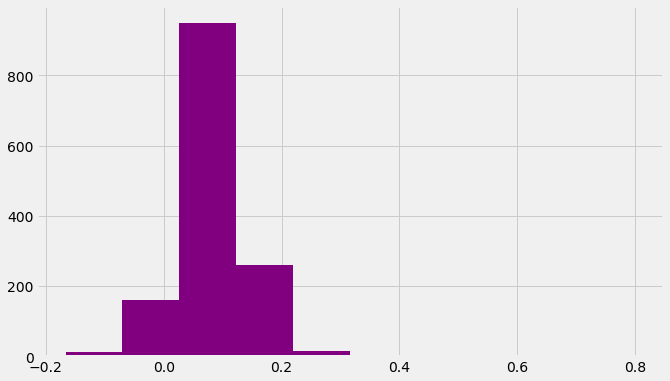

In [71]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

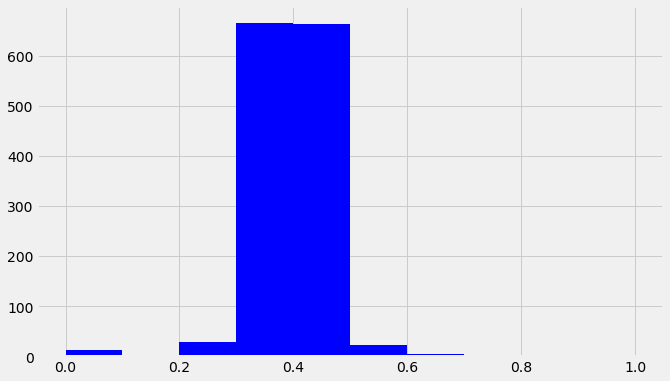

In [72]:

plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [73]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394,-0.7579,0.207,0.649,0.144
...,...,...,...,...,...,...,...,...
1395,2004-12-09,madra hc refus grant bail kanchi seer india ho...,0.483466,0.044768,-0.9565,0.136,0.756,0.109
1396,2004-12-10,politician corrupt say indian brute forc engli...,0.323097,0.124429,-0.7717,0.119,0.768,0.113
1397,2004-12-11,keep channel open trai tell broadcast us waiv ...,0.368564,0.091771,-0.9590,0.131,0.788,0.081
1398,2004-12-12,strip tonsur flog love bomb blast srk show kil...,0.403276,0.106394,0.1027,0.129,0.740,0.130


In [74]:
df_merge = pd.merge(dataset, df_news, how='inner', on='Date')
df_merge.head()

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0,sangh parivar babri panel ant frontrunn key us...,0.486204,-0.035142,-0.6808,0.100,0.816,0.084


In [75]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,4018.879883,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,4060.020020,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,4115.370117,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,4183.729980,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,4120.430176,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
...,...,...,...,...,...,...,...
949,6322.500000,0.398988,0.078451,-0.8779,0.115,0.774,0.110
950,6316.279785,0.381942,0.110994,-0.9944,0.145,0.776,0.079
951,6261.520020,0.330339,0.067713,-0.9517,0.110,0.799,0.091
952,6304.270020,0.483466,0.044768,-0.9565,0.136,0.756,0.109


In [76]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.380537,0.298148,0.553906,0.072302,0.382263,0.699735,0.134921
1,0.391571,0.429167,0.393592,0.200712,0.403670,0.675926,0.149471
2,0.406417,0.475140,0.409783,0.960991,0.302752,0.723545,0.145503
3,0.424753,0.458412,0.980975,0.320146,0.522936,0.548942,0.224868
4,0.407775,0.486204,0.263429,0.159898,0.305810,0.756614,0.111111


In [77]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [78]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.298148,0.553906,0.072302,0.382263,0.699735,0.134921
1,0.429167,0.393592,0.200712,0.403670,0.675926,0.149471
2,0.475140,0.409783,0.960991,0.302752,0.723545,0.145503
3,0.458412,0.980975,0.320146,0.522936,0.548942,0.224868
4,0.486204,0.263429,0.159898,0.305810,0.756614,0.111111


In [79]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(763, 6)

In [80]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
412,0.340855,0.384808,0.001554,0.504587,0.657407,0.124339
863,0.443984,0.571002,0.007170,0.412844,0.678571,0.142857
62,0.421970,0.548531,0.814581,0.235474,0.657407,0.240741
79,0.392574,0.710656,0.214501,0.489297,0.596561,0.191799
649,0.381099,0.307438,0.000351,0.480122,0.698413,0.093915
193,0.371473,0.440324,0.000100,0.486239,0.689153,0.100529
181,0.439321,0.531369,0.001604,0.501529,0.649471,0.133598
526,0.338272,0.501395,0.000150,0.550459,0.649471,0.112434
725,0.350583,0.699835,0.003710,0.394495,0.716931,0.111111
306,0.356506,0.540867,0.000150,0.510703,0.667989,0.111111


In [81]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [90]:
print(prediction[:10])
print(y_test[:10])
print("******************************************")
print("Mean squared error:" ,mean_squared_error(prediction,y_test))

[0.364517   0.59758936 0.3479669  0.44357719 0.39519765 0.28864354
 0.23381145 0.56325999 0.57836017 0.39762384]
876    0.676856
900    0.809147
14     0.469955
702    0.705204
55     0.156545
425    0.076472
200    0.193160
255    0.269280
267    0.250966
809    0.610706
Name: Close, dtype: float64
******************************************
Mean squared error: 0.06053546019763283


**Conclusion**: I have used Attention mechanism with LSTM for training the numerical data for BSESN. And used Random Forest for training the texual data. The Mean squared error obtained for numerical analsysis is 0.0135 and that for texual analysis is 0.605